<span style="font-size:250%">But actually, we want to analyze repos ...</span>

This notebook was aimed at developing the methodology to analyze repositories fast.
It also includes the actual analysis runs. From the results of this notebook, the [repoAnalysis.py](./repoAnalysis.py) module was created.
Additionally the [RepoLibrarian](./RepoLibrarian.ipynb) notebook that aims at managing downloaded repos split off this notebook.

In [1]:
import re
import matplotlib.pyplot as pyplot
import matplotlib
import time
from datetime import datetime
from multiprocessing import Pool
import multiprocessing
import functools

In [2]:
%load_ext autoreload
%aimport repoLibrarian
%aimport repoAnalysis
%autoreload

---
### Set repos work folder
(Initially I downloaded the repositories to a more local folder, which I later used a small test set for developing analysis routines)

Shared folder:

In [33]:
repoLibrarian.setReposFolder('/mnt/brick/crm20/repos/')

'/mnt/brick/crm20/repos/'

Local folder:

In [31]:
repoLibrarian.setReposFolder('./repos/')

'./repos/'

In [34]:
repoLibrarian.getReposFolder()

'/mnt/brick/crm20/repos/'

---
# Developing an approach to analyze a given set of repos

After analyzing repositories was generally possible (see [historical RepoAnalysis](./RepoAnalysis_Historical.ipynb) notebook), a suitable approach to do this on a large scale for multiple repositories and multiple metrics had to be developed.

The following function aggregates the knowledge . Runs a function for all files of all commits of a repo. Aggregates for each commit and combines with the counted files.

Note: This function was once located in the [repoAnalysis.py](./repoAnalysis.py) module, but has been moved back to the notebook to collect all historical information in the notebooks and keep the modules clean.

In [40]:
def timedMetricPerFileForRepo(repoTuple, metricFunction, fileCountConsumer = repoAnalysis.safeDivision):
    (user, project) = repoTuple
    repo = repoLibrarian.getRepo(user, project)
    timestamps = []
    metrics = []
    try:
        start = time.time()
        for commit in repo.iter_commits():
            fileCount = 0
            aggregatedMetric = 0
            for obj in commit.tree.traverse():
                if obj.type == 'blob' and obj.name.endswith('.java'):
                    fileCount = fileCount + 1
                    content = obj.data_stream.read().decode("CP437")#.decode("utf-8")
                    metric = metricFunction(content)
                    aggregatedMetric = aggregatedMetric + metric
            metrics.append(fileCountConsumer(aggregatedMetric, fileCount))
            timestamps.append(commit.committed_date)

        end = time.time()
        print('Time used for '+str(repoTuple)+': '+str(end - start))
#        while len(metrics) > 0 and metrics[-1] < 1:
#            metrics.pop()
#            timestamps.pop()
        return (timestamps, metrics)
    except Exception as e:
        print('Failed to analyze '+str(repoTuple)+': '+str(e))
        return ([],[])

In [36]:
from os import listdir


def simpleRunMetric(metricFunction, fileCountConsumer = repoAnalysis.safeDivision):
    repos = list(map(lambda repo: (repo.split('/', 1)[0], repo.split('/', 1)[1]), repoLibrarian.knownRepos()))

    start = time.time()
    with Pool(int(multiprocessing.cpu_count())) as pool:
        allMetrics = pool.map(functools.partial(timedMetricPerFileForRepo, metricFunction=metricFunction, fileCountConsumer=fileCountConsumer), repos)
    end = time.time()
    print('Total Time used: '+str(end - start))
    return allMetrics

### Running metrics

In [23]:
allMetrics = simpleRunMetric(locmOf)

Time used for ('bptlab', 'fcm2cpn.git'): 0.32309722900390625
Time used for ('bptlab', 'correlation-analysis.git'): 6.87972354888916
Time used for ('bptlab', 'scylla.git'): 44.216235399246216
Time used for ('json-iterator', 'java.git'): 48.26174259185791
Time used for ('bptlab', 'cepta.git'): 61.69267416000366
Time used for ('bptlab', 'Unicorn.git'): 69.90817427635193
Time used for ('alibaba', 'arthas.git'): 191.63405680656433
Total Time used: 194.1722662448883


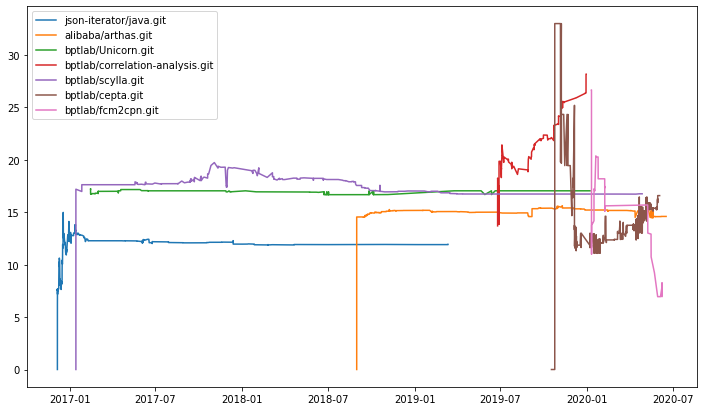

In [16]:
pyplot.figure(figsize=(12, 7))
for (timestamps, metrics) in allMetrics:
    dates = matplotlib.dates.epoch2num(timestamps)
    pyplot.plot_date(dates, metrics, '-')

pyplot.legend(list(knownRepos()))

Time used for ('bptlab', 'fcm2cpn.git'): 0.2428593635559082
Time used for ('bptlab', 'correlation-analysis.git'): 5.369837522506714
Time used for ('bptlab', 'scylla.git'): 23.692981958389282
Time used for ('json-iterator', 'java.git'): 25.463353395462036
Time used for ('bptlab', 'cepta.git'): 50.5887086391449
Time used for ('bptlab', 'Unicorn.git'): 52.17696785926819
Total Time used: 52.98057174682617


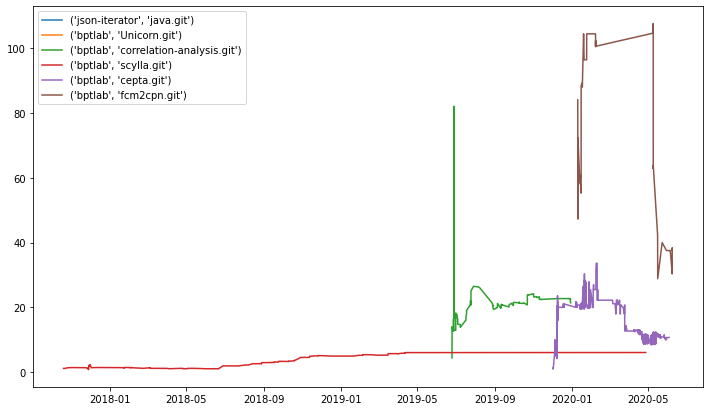

In [38]:
simpleRunMetric(lambdaDensity)

Time used for ('Elena-Zhao', 'Guimi.git'): 0.1284182071685791
Time used for ('Elena-Zhao', 'Mini-Chatter.git'): 0.10931038856506348
Time used for ('pleonex', 'ChatRMI.git'): 0.1066889762878418
Time used for ('craigslist206', 'huffman.git'): 0.16383004188537598
Time used for ('Elena-Zhao', 'Weibao.git'): 0.24792146682739258
Time used for ('pleonex', 'CocoKiller.git'): 0.2406604290008545
Time used for ('miken22', '304-Project.git'): 0.24741840362548828
Time used for ('bptlab', 'fcm2cpn.git'): 0.2866392135620117
Time used for ('pleonex', 'NiKate-Origins.git'): 0.39778637886047363
Time used for ('JTReed', 'Porygon.git'): 0.21101975440979004
Failed to analyze ('braliar', 'jabref.git'): Reference at 'refs/heads/master' does not exist
Time used for ('tyler124', 'Monitordroid.git'): 0.23861050605773926
Time used for ('GourdErwa', 'jasper_sample.git'): 0.2540762424468994
Time used for ('JTReed', 'Porygon2.git'): 0.4825553894042969
Time used for ('shengnwen', 'WeiBaoSSE.git'): 0.5534257888793945

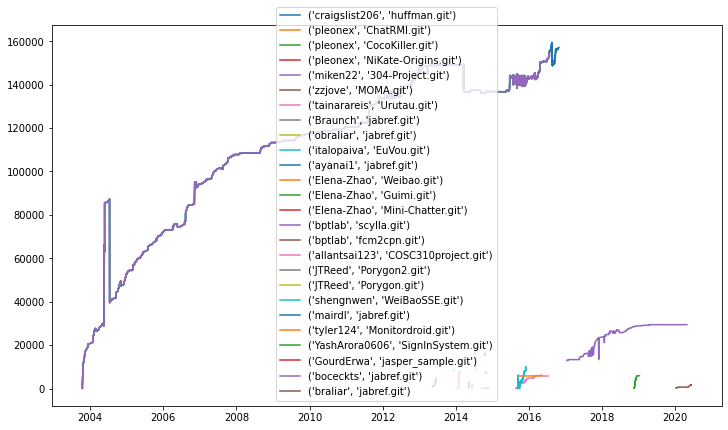

In [62]:
simpleRunMetric(loc, identity)

In [63]:
print(hasRepo('braliar','jabref'))
repo = getRepo('boceckts', 'jabref')
commit = next(repo.iter_commits())
for obj in commit.tree.traverse():
    if obj.type == 'blob' and obj.name.endswith('.java'):
        print(obj.name)
        content = obj.data_stream.read().decode("CP437")
        metric = loc(content)

True
MacAdapter.java
BibDatabaseContext.java
Defaults.java
Globals.java
JabRefException.java
JabRefExecutorService.java
JabRefGUI.java
JabRefMain.java
MetaData.java
ArchitectureTests.java
BibDatabaseContextTest.java
BibtexTestData.java
FileBasedTestCase.java
FileBasedTestHelper.java
JabRefPreferencesTest.java
MetaDataTest.java
SearchQueryHighlightListenerTest.java
TestIconsProperties.java
AWTExceptionHandler.java
AbstractUITest.java
EntryTableTest.java
GUITest.java
UndoTest.java
Benchmarks.java
ArgumentProcessor.java
AuxCommandLine.java
JabRefCLI.java
Change.java
ChangeDisplayDialog.java
ChangeScanner.java
EntryAddChange.java
EntryChange.java
EntryDeleteChange.java
FileUpdateListener.java
FileUpdateMonitor.java
FileUpdatePanel.java
GroupChange.java
InfoPane.java
MetaDataChange.java
PreambleChange.java
StringAddChange.java
StringChange.java
StringNameChange.java
StringRemoveChange.java
AttachFileAction.java
AutoSetLinks.java
ConfirmCloseFileListEntryEditor.java
DownloadExternalFile.java

# Now bringing the user in

In [10]:
# Delete all the duplicates except the newest
for (user, repo) in repoLibrarian.managedRepos():
    if repo.endswith('jabref.git') and not 'mairdl' in user:
        deleteRepo(user, repo)

In [66]:
basicJavaRepos = list(filter(isJavaRepo, repoLibrarian.managedRepos()))
for x in basicJavaRepos: print(x)

('json-iterator', 'java.git')
('alibaba', 'arthas.git')
('bptlab', 'Unicorn.git')
('bptlab', 'correlation-analysis.git')
('bptlab', 'scylla.git')
('bptlab', 'cepta.git')
('bptlab', 'fcm2cpn.git')


In [197]:
import collections

class Wrap:
    def __init__(self, data):
        self.data = data

def averageMetricPerCommitForRepo(repoTuple, metricFunction, fileCountConsumer = repoAnalysis.safeDivision):
    (user, project) = repoTuple
    repo = getRepo(user, project)
    try:
        start = time.time()
        commitToMetric = collections.OrderedDict()
        for commit in repo.iter_commits():
            fileCount = 0
            aggregatedMetric = 0
            totalLoc = 0
            for obj in commit.tree.traverse():
                if isJavaFile(obj):
                    fileCount = fileCount + 1
                    content = obj.data_stream.read().decode("CP437")#.decode("utf-8")
                    loc = repoAnalysis.loc(content)
                    metric = metricFunction(content, loc=loc)
                    aggregatedMetric = aggregatedMetric + metric
                    totalLoc = totalLoc + loc
            consumedMetric = fileCountConsumer(aggregatedMetric, fileCount)
            parent = commit.parents[-1].hexsha if len(commit.parents) == 1 else None
            commitToMetric[commit.hexsha] = (commit.committed_date, consumedMetric, parent, totalLoc)
        end = time.time()
        print('Time used for '+str(repoTuple)+': '+str(end - start))
    except Exception as e:
        print('Failed to analyze '+str(repoTuple)+': '+str(e))
    return Wrap(commitToMetric)

In [216]:
def deltasOf(metricPerCommit):
    deltas = collections.OrderedDict()
    for (sha, metric) in metricPerCommit.items():
        if(metric[2] != None): #There is a unique parent -> No merges or orphans(initial commit)
            parentMetric = metricPerCommit[metric[2]]
            deltas[sha] = (metric[0], (metric[1] - parentMetric[1]), metric[2])
    return deltas

In [19]:
def plotByDate(data):
    timestamps = map(lambda tuple: tuple[0], data)
    metrics = map(lambda tuple: tuple[1], data)
    dates = matplotlib.dates.epoch2num(list(timestamps))
    pyplot.plot_date(dates, list(metrics), '-')

In [20]:
def plotByLifecycle(data):
    if len(data) == 0:
        pyplot.plot([], [])
        return
    timestamps = map(lambda tuple: tuple[0], data)
    metrics = map(lambda tuple: tuple[1], data)
    maxDate = next(iter(data))[0]
    minDate = next(reversed(data))[0]
    interval = maxDate - minDate
    dates = list(map(lambda stamp : (stamp - minDate) / interval, timestamps))
    pyplot.plot(dates, list(metrics), '-')

### Testing if plot functions are sane

In [ ]:
data = averageMetricPerCommitForRepo(('bptlab', 'scylla'), repoAnalysis.locmOf).data

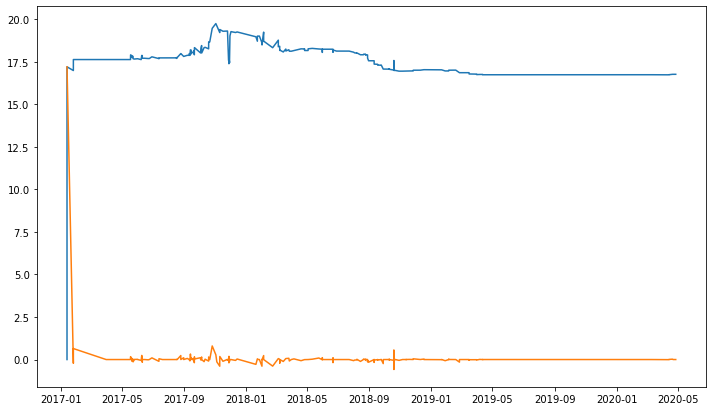

In [67]:
pyplot.figure(figsize=(12, 7))
deltas = deltasOf(data)
plotByDate(data.values())
plotByDate(deltas.values())

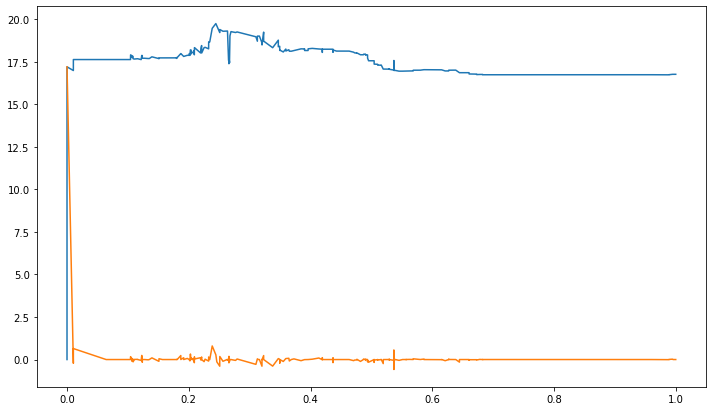

In [69]:
pyplot.figure(figsize=(12, 7))
plotByLifecycle(data)
plotByLifecycle(deltas)

## Run metrics for multiple repos

In [29]:
# from multiprocessing.pool import ThreadPool
# import consumers

start = time.time()
with Pool(int(multiprocessing.cpu_count()/4)) as pool:
    #allMetrics = pool.map(lambda repo: averageMetricPerCommitForRepo(repoTuple=repo, metricFunction=locmOf), basicJavaRepos)
    allMetrics = pool.map(functools.partial(averageMetricPerCommitForRepo, metricFunction=repoAnalysis.locmOf), basicJavaRepos)
allMetrics = list(map(lambda wrap: wrap.data, allMetrics))
chainMap = collections.ChainMap(*allMetrics)
end = time.time()
print('Total Time used: '+str(end - start))

Time used for ('bptlab', 'fcm2cpn.git'): 0.410602331161499
Time used for ('bptlab', 'correlation-analysis.git'): 3.3247828483581543
Time used for ('bptlab', 'scylla.git'): 27.353537559509277
Time used for ('json-iterator', 'java.git'): 29.815542936325073
Time used for ('bptlab', 'cepta.git'): 32.99368500709534
Time used for ('bptlab', 'Unicorn.git'): 38.291534662246704
Time used for ('alibaba', 'arthas.git'): 160.3558988571167
Total Time used: 161.17432641983032


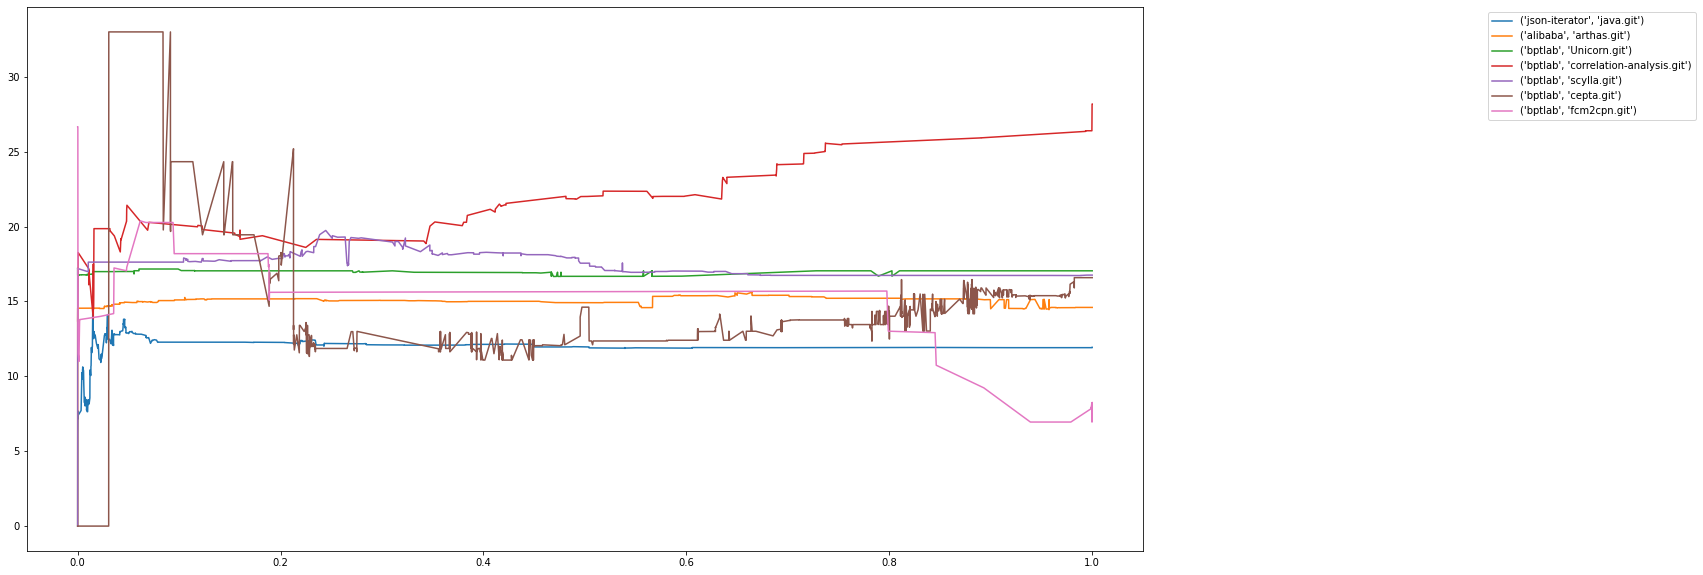

In [35]:
# reposToMetrics = dict(zip(repos, allMetrics))

pyplot.figure(figsize=(20, 10))
for data in allMetrics:
    plotByLifecycle(
        #deltasOf(
            data.values()
        #)
    )

pyplot.legend(basicJavaRepos, bbox_to_anchor=(1.5, 1.0))

In [20]:
sha = next(iter(next(iter(allMetrics))))
print(chainMap.get(sha, default=None))

(1552402499, 11.935117352548417, None)


# Starting to run suites and generate database

In [11]:
%load_ext autoreload
%aimport repoAnalysis
%aimport dbUtils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
%autoreload 2
suite = repoAnalysis.metricSuite
data = repoAnalysis.calculateMetrics(('bptlab', 'scylla', 123456789), suite)
data

Time used for ('bptlab', 'scylla', 123456789): 37.73695778846741


,sha,parent,timestamp,repoId,loc,cloc,fileCount,numMethods,numLambdas,numCommentLines,numReflection,numSnakes,totalIndent
0,ee00a205a2225ad73b0264cf7ba64be5c7044d0b,aa9335c1b629e660d48cf6cb923bf345f79f0619,1587919939,123456789,29423,25301,271,1609,225,4184,93,1736,56348.00
1,aa9335c1b629e660d48cf6cb923bf345f79f0619,b215b9f8ea72fcbadb5881c73ed949a21f456601,1587456806,123456789,29421,25301,271,1609,225,4184,93,1736,56348.00
2,b215b9f8ea72fcbadb5881c73ed949a21f456601,d27a25f6aca8eb7820b5ee4e2d87f65ecf7c454e,1587369531,123456789,29419,25299,271,1609,225,4184,93,1736,56344.00
3,d27a25f6aca8eb7820b5ee4e2d87f65ecf7c454e,42b3c179a26bbd0c06a84d257f4a0d5497f54a5a,1586774875,123456789,29413,25293,271,1609,225,4178,93,1736,56338.75
4,42b3c179a26bbd0c06a84d257f4a0d5497f54a5a,52d70ef3d86c0c92cca31e33b068792c4cc09f44,1586773854,123456789,29450,25328,271,1611,225,4208,93,1736,56372.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,3a525dd8c0178158275815e47e6f7970372489df,a019eafb85e1d093b5a9ac75792d3c3793e0fcfe,1485388416,123456789,13323,11156,164,704,15,1477,33,122,26513.00
293,a019eafb85e1d093b5a9ac75792d3c3793e0fcfe,None,1485387515,123456789,12972,10850,158,691,15,1454,31,117,25773.50
294,411d51771ee6c714db13c23e8912086840b84f51,9e8faf6f0b516334451c53960dee001a6e9e42c4,1485386460,123456789,12972,10850,158,691,15,1454,31,117,25773.50
295,9e8faf6f0b516334451c53960dee001a6e9e42c4,e1ca54916ff570656eb1d40c13b7e58c10d8bc0a,1484305822,123456789,12922,10795,155,686,15,1466,30,117,25716.50


In [71]:
from sqlalchemy import MetaData, Table, Column, Integer, String
columns = [Column('sha', String), Column('parent', String), Column('timestamp', Integer), Column('repoId', Integer)]
columns = columns + list(map(lambda func: Column(func.__name__, Integer), suite))
meta = MetaData(schema='crm20')
tableName = 'lb_test2'
table = Table(
    tableName, meta,
    *columns
)
meta.create_all(dbUtils.engine)

In [78]:
data.to_sql(tableName, schema='crm20', con=dbUtils.engine, if_exists='append', index=False)

In [355]:
dbUtils.runQuery('''
    select column_name, data_type from information_schema.columns
    where table_name = '''+"'"+tableName+'''';
''')

Time used: 0.3105020523071289


,column_name,data_type
0,totalIndent,integer
1,numReflection,integer
2,numSnakes,integer
3,timestamp,integer
4,repoId,integer
5,loc,integer
6,cloc,integer
7,fileCount,integer
8,numMethods,integer
9,numLambdas,integer


# Running the suites

In [23]:
import time
from datetime import datetime
from multiprocessing import Pool
from multiprocessing import Semaphore
import multiprocessing
import sqlalchemy
import pandas
from IPython.utils import io
from IPython.display import Audio

In [4]:
%load_ext autoreload
%autoreload 2
%aimport repoAnalysis
%aimport repoLibrarian
%aimport dbUtils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
suite = repoAnalysis.metricSuite

In [6]:
from sqlalchemy import MetaData, Table, Column, Integer, String
def deleteTable():
    try:
        dbUtils.runQuery('''
            DROP TABLE crm20.'''+tableName+'''
        ''')
    except:
        pass
    
dataBaseSemaphore = multiprocessing.Semaphore()
logSemaphore = multiprocessing.Semaphore()

def log(text):
    with logSemaphore:
        with open('log.txt', 'a') as file:
            file.write('========= '+str(datetime.now())+' ==========\n'+str(text))

In [7]:
def writeDataToDb(data):
    with dataBaseSemaphore:
        data.to_sql(tableName, schema='crm20', con=dbUtils.engine, if_exists='append', index=False)
        dbUtils.engine.dispose()

In [8]:
def rowToTuple(x):
    (index, row) = x
    split = row['url'].split('/')
    user = split[-2]
    project = split[-1]
    return (user, project, row['repo_id'])

### First iteration

In [ ]:
tableName = 'lb_results'

In [ ]:
def createTable():
    columns = [Column('sha', String), Column('parent', String), Column('timestamp', Integer), Column('repoId', Integer)]
    columns = columns + list(map(lambda func: Column(func.__name__, Integer), suite))
    meta = MetaData(schema='crm20')
    table = Table(
        tableName, meta,
        *columns
    )
    meta.create_all(dbUtils.engine)
    dbUtils.engine.dispose()

In [8]:
def runSuite(repo):
    with io.capture_output() as output:
        data = repoAnalysis.calculateMetrics(repo, suite)
        with dataBaseSemaphore:
            data.to_sql(tableName, schema='crm20', con=dbUtils.engine, if_exists='append', index=False)
            dbUtils.engine.dispose()
    log(output)
    return len(data) > 0

In [9]:
repoLibrarian.setReposFolder('/mnt/brick/crm20/repos/')

'/mnt/brick/crm20/repos/'

In [14]:
polyglotProjects = dbUtils.runQuery('''SELECT * FROM lb_polyglotProjects''')
controlgroupProjects = dbUtils.runQuery('''SELECT * FROM lb_controlgroupProjects''')
bothProjects = pandas.concat([polyglotProjects, controlgroupProjects], axis=0)

Time used: 0.37739133834838867


Time used: 0.36337733268737793


In [16]:
repos = list(filter(lambda tupl: repoLibrarian.isJavaRepo(tupl[0], tupl[1]), map(rowToTuple, bothProjects.iterrows())))

Failed to check ('thiagoruis', 'dotNET-Grupo-2'): Reference at 'refs/heads/master' does not exist
Could not download repo "tananaev/traccar-client": Cmd('git') failed due to: exit code(128)
  cmdline: git clone --bare -v https://github.com/tananaev/traccar-client.git /mnt/brick/crm20/repos/tananaev/traccar-client.git
  stderr: 'Cloning into bare repository '/mnt/brick/crm20/repos/tananaev/traccar-client.git'...
fatal: could not read Username for 'https://github.com': No such device or address
'
Failed to check ('tananaev', 'traccar-client'): Reference at 'refs/heads/master' does not exist
Could not download repo "topicusonderwijs/wicket-openid": Cmd('git') failed due to: exit code(128)
  cmdline: git clone --bare -v https://github.com/topicusonderwijs/wicket-openid.git /mnt/brick/crm20/repos/topicusonderwijs/wicket-openid.git
  stderr: 'Cloning into bare repository '/mnt/brick/crm20/repos/topicusonderwijs/wicket-openid.git'...
fatal: could not read Username for 'https://github.com': No

In [700]:
print(len(bothProjects))
print(len(repos))

1377
620


In [ ]:
deleteTable()
createTable()
#repos = list(map(lambda tupl: (*tupl, int.from_bytes(bytearray(str(tupl), 'utf-8'), byteorder='big', signed=False) % 10000000), repoLibrarian.managedRepos()))
start = time.time()
with Pool(int(multiprocessing.cpu_count()/4)) as pool:
    allMetrics = pool.map(runSuite, repos)
end = time.time()
log('Total Time used: '+str(end - start))

## Second iteration

In [9]:
tableName = 'lb_results2'

In [10]:
def createTable():
    columns = [Column('sha', String), Column('parent', String), Column('timestamp', Integer), Column('repo_id', Integer), Column('additions', Integer), Column('deletions', Integer)]
    columns = columns + list(map(lambda func: Column(func.__name__, Integer), suite))
    meta = MetaData(schema='crm20')
    table = Table(
        tableName, meta,
        *columns
    )
    meta.create_all(dbUtils.engine)
    dbUtils.engine.dispose()

In [11]:
def runDeltaSuite(repo):
    with io.capture_output() as output:
        data = repoAnalysis.calculateDeltaMetrics(repo, suite)
        writeDataToDb(data)
    log(output)
    return len(data) > 0

In [12]:
repoLibrarian.setReposFolder('/mnt/brick/crm20/repos/')

'/mnt/brick/crm20/repos/'

In [13]:
polyglotProjects = dbUtils.runQuery('''SELECT * FROM lb_polyglotProjects''', mute=True)
controlgroupProjects = dbUtils.runQuery('''SELECT * FROM lb_controlgroupProjects''', mute=True)
bothProjects = pandas.concat([polyglotProjects, controlgroupProjects], axis=0)

Time used: 0.4349958896636963
Time used: 0.34889984130859375


In [24]:
start = time.time()
repos = list(filter(lambda tupl: repoLibrarian.isJavaRepo(tupl[0], tupl[1]), map(rowToTuple, bothProjects.iterrows())))
end = time.time()
log('Total Time used: '+str(end - start))

Failed to check ('thiagoruis', 'dotNET-Grupo-2'): Reference at 'refs/heads/master' does not exist
Failed to check ('tananaev', 'traccar-client'): Reference at 'refs/heads/master' does not exist
Failed to check ('topicusonderwijs', 'wicket-openid'): Reference at 'refs/heads/master' does not exist
Failed to check ('dav009', 'graficadora-tweets'): Reference at 'refs/heads/master' does not exist
Failed to check ('dav009', 'MWE-DictionaryExtractor'): Reference at 'refs/heads/master' does not exist
Failed to check ('OpenGamma', 'OG-RStats'): Reference at 'refs/heads/master' does not exist


KeyboardInterrupt: 

In [25]:
print(len(bothProjects))
print(len(repos))

1377
620


In [26]:
log('test')

#### Dry test to see if everything is up

In [21]:
repos[0]

('twitter', 'scalding', 1182)

In [27]:
deleteTable()
createTable()
runDeltaSuite(repos[0])
display(Audio('./beep.mp3', autoplay=True))

#### Let's go

In [ ]:
deleteTable()
createTable()
start = time.time()
with Pool(int(multiprocessing.cpu_count()*3/4)) as pool:
    allMetrics = pool.map(runDeltaSuite, repos)
end = time.time()
log('Total Time used: '+str(end - start))

---
# Can we get commit changes information from repositories? <a class="anchor" id="analysis-second"></a>
### (And can we do it fast enough?)

In [359]:
testRepoId = ('tfox12', 'REST-Debugger')

In [360]:
repoLibrarian.hasRepo(*testRepoId)

True

In [412]:
from git.db import GitDB
from git.db import GitCmdObjectDB
from git import Repo 

In [586]:
testRepo = Repo.init(repoLibrarian.pathFor(*testRepoId), bare=True, odbt=GitCmdObjectDB)

In [418]:
start = time.time()
for commit in testRepo.iter_commits():
    for obj in commit.tree.traverse():
        if obj.type == 'blob' and obj.name.endswith('.java'):
            contentWithHeader = obj.data_stream.read().decode("CP437")#.decode("utf-8")
end = time.time()
print('Total Time used: '+str(end - start))

start = time.time()
res = []
for commit in testRepo.iter_commits():
    for obj in commit.tree.traverse():
        if obj.type == 'blob' and obj.name.endswith('.java'):
            contentWithHeader = obj.data_stream.read().decode("CP437")#.decode("utf-8")
    res.append(sum(map(lambda file: file[1]['lines'], (filter(lambda file: file[0].endswith('.java'), commit.stats.files.items())))))
end = time.time()
print('Total Time used: '+str(end - start))

Total Time used: 5.757571458816528
Total Time used: 140.97127866744995


In [477]:
EMPTY_TREE_SHA   = "4b825dc642cb6eb9a060e54bf8d69288fbee4904"
start = time.time()
res = []
for commit in testRepo.iter_commits():
    for obj in commit.tree.traverse():
        if obj.type == 'blob' and obj.name.endswith('.java'):
            contentWithHeader = obj.data_stream.read().decode("CP437")#.decode("utf-8")
    if len(commit.parents) == 1:
        print(testRepo.git.diff(commit.parents[0].hexsha, commit.hexsha, '--', numstat=True))
end = time.time()
print('Total Time used: '+str(end - start))

144	0	web/lib/debugger.js
1	1	src/capstone/wrapper/GdbWrapper.java
11	5	web/test.html
22	2	src/capstone/wrapper/GdbWrapper.java
2	1	makefile
11	0	src/capstone/daemon/DaemonHandler.java
1	1	src/capstone/wrapper/PdbWrapper.java
2	0	test/capstone/wrapper/GdbWrapperTest.java
20	108	web/test.html
10	6	src/capstone/daemon/DaemonHandler.java
231	0	src/capstone/wrapper/PdbWrapper.java
129	123	src/capstone/wrapper/Wrapper.java
31	0	test/capstone/wrapper/PdbWrapperTest.java
1	0	.gitignore
5	1	src/capstone/wrapper/Wrapper.java
12	2	src/capstone/wrapper/GdbWrapper.java
1	1	src/capstone/wrapper/Wrapper.java
1	1	src/capstone/util/StackFrame.java
1	1	src/capstone/daemon/DaemonHandler.java
0	1	src/capstone/wrapper/GdbWrapper.java
1	1	src/capstone/daemon/DaemonHandler.java
1	0	src/capstone/wrapper/Wrapper.java
57	3	src/capstone/wrapper/GdbWrapper.java
2	2	src/capstone/wrapper/Wrapper.java
5	0	test/capstone/wrapper/GdbWrapperTest.java
28	15	src/capstone/wrapper/GdbWrapper.java
120	13	src/capstone/wrappe

KeyboardInterrupt: 

- That works, but the needed time is far too bad
- Try to look into internals of gitpython, iterating over commits (and all files!) is fast
- Iterates over revlist and create commit for each ... testRepo.git.rev_list(testRepo.head.commit))
- Iterating over objects of commit needs irritatingly little time -> iter_commits needs 90% of time
- The time is spend in cmd.py>>_call_process which is aliased with `__getattr__` --> gets called on attribute getting
- Comes from repo.git which is GitCommandWrapperType which is cmd.py>>Git
- `_iter_from_process_or_stream` just reads hexshas and reads commits
- `data_stream` calls odb.stream(binsha)
- So file contents are accessed directly via a hash - no way for me to get the diff that way...

Soooo, remember iter_commits taking 90% of time? That's because it calling rev-list. If we replace that with a git log --numstats, it's not much slower but we get detailed diff information - we can filter that for java files and sum up and even pursue a diff-based approach instead of calculating the whole project metrics every time

In [482]:
def toPrun():
    for commit in testRepo.iter_commits():
        for obj in commit.tree.traverse(predicate=lambda obj, depth: obj.type == 'blob' and obj.name.endswith('.java')):
            contentWithHeader = obj.data_stream.read().decode("CP437")#.decode("utf-8")
            print(commit.stats.files.items())
#%prun -s cumulative toPrun()
toPrun()

dict_items([('web/lib/debugger.js', {'insertions': 144, 'deletions': 0, 'lines': 144})])
dict_items([('web/lib/debugger.js', {'insertions': 144, 'deletions': 0, 'lines': 144})])
dict_items([('web/lib/debugger.js', {'insertions': 144, 'deletions': 0, 'lines': 144})])
dict_items([('web/lib/debugger.js', {'insertions': 144, 'deletions': 0, 'lines': 144})])
dict_items([('web/lib/debugger.js', {'insertions': 144, 'deletions': 0, 'lines': 144})])
dict_items([('web/lib/debugger.js', {'insertions': 144, 'deletions': 0, 'lines': 144})])
dict_items([('web/lib/debugger.js', {'insertions': 144, 'deletions': 0, 'lines': 144})])
dict_items([('web/lib/debugger.js', {'insertions': 144, 'deletions': 0, 'lines': 144})])


KeyboardInterrupt: 

In [469]:
from git.objects import Commit
proc = testRepo.git.rev_list(testRepo.head.commit, as_process=True)
print(proc)
commits = Commit._iter_from_process_or_stream(testRepo, proc)
for commit in commits:
    print(commit.hexsha)

ea393258a29f93539e371156cb77ea8eb2755b31
8a94a36e5448dd83ef4dafc76cc7650e8b20f791
cf84234e66b5a9940a3654b3bf6c17e8ec23e03c
468a8e7939c7328d3af5b95fe8c6832966df1b52
e78ae0397b209312ba80b709ba6996b558bb13bf
d85a3642c97d44d6c4b0bcd145c68f420b3c2d96
9dcfe3d3e498dfb06ae0f8c00dd1eda72bda070d
81a242f338713512b8d6b52d2a228a2be2f70d27
6fcc68689f3772ecaa1a6a011510ff26d7ee48d6
3f93813edef9786f6cb8ced6a7441783da3f8884
34503c976c764ce103baf2c10721ffa3656f20f8
1b3e586b70006b9a21d9a35c5029c1e48cd95837
a198e51031eadf8a013cc3711e37656f9edbe27b
3682dc8523e86a00251a237258047429c1bb6cf9
58c4dcce5ee8f618c0b12fd9053a79df8558b5a6
0f4e0bb6b43d088baca4e874d2641c6bc3e427cf
49f326042cf26b2b9ead9b675b6a830704092fa3
5be9b9fa33c509896fc1ad3c0e9d09680135153f
e7576bd7f72e7e5286d23bbad167cf3f394bed9c
ed4dd39de749f287ad3036832ebcf24126140b72
6c51645d3341163b45552ccfc47c162c8a0d0dc8
377ccc918b4b7d3f390bcba84777e1555e501622
0c5ddda62b6911aaec177be1f0e3d028dd94f94c
9c6d5dd48018dc9d72d952913f3c3f9c92530574
4048f135cdc7a3de

In [476]:
testRepo.git.for_each_ref()

'ea393258a29f93539e371156cb77ea8eb2755b31 commit\trefs/heads/master'

In [711]:
start = time.time()
res = []
for commit in testRepo.iter_commits():
    for obj in commit.tree.traverse():
        if obj.type == 'blob' and obj.name.endswith('.java'):
            contentWithHeader = obj.data_stream.read().decode("CP437")#.decode("utf-8")
    if len(commit.parents) == 1:
        print(testRepo.git.diff('--shortstat', commit.parents[0].hexsha, commit.hexsha))
end = time.time()
print('Total Time used: '+str(end - start))

 3 files changed, 8 insertions(+), 6 deletions(-)
 1 file changed, 3 insertions(+), 1 deletion(-)
 2 files changed, 11 insertions(+), 5 deletions(-)
 6 files changed, 179 insertions(+), 216 deletions(-)
 7 files changed, 178 insertions(+), 161 deletions(-)


KeyboardInterrupt: 

In [559]:
import diff as diff_lib
start = time.time()
for commit in testRepo.iter_commits():
    if len(commit.parents) == 1:
        #print(commit.hexsha)
        for obj in commit.tree.traverse(predicate=lambda obj, depth: obj.type == 'blob' and obj.name.endswith('.java')):
            try:
                obj2 = commit.parents[0].tree / obj.path
                content1 = obj.data_stream.read().decode("CP437")#.decode("utf-8")
                content2 = obj2.data_stream.read().decode("CP437")#.decode("utf-8")
                if not (content1 == content2):
                    #print('\tchanged '+obj.path)
                    diff = diff_lib.diff(content1.split('\n'), content2.split('\n'))
                    additions = sum(map(lambda change: change[1], diff))
                    deletions = sum(map(lambda change: change[3], diff))
                    #print(str(additions)+'\t'+str(deletions)+'\t'+obj.path)
            except KeyError:
                pass
                #print('\tadded '+obj.path)
        #print('---\n'+testRepo.git.diff(commit.parents[0].hexsha, commit.hexsha, '--', numstat=True))
        print(testRepo.git.diff(commit.parents[0].hexsha, commit.hexsha))
        #print('\n')
end = time.time()
print('Total Time used: '+str(end - start))

diff --git a/web/lib/debugger.js b/web/lib/debugger.js
new file mode 100644
index 0000000..a6f5752
--- /dev/null
+++ b/web/lib/debugger.js
@@ -0,0 +1,144 @@
+// Debugger Web API
+// Author: ntietz
+// Date:   April 19 2013
+
+var currentline = 1;
+var userId = 1;
+var debuggerId = 1;
+
+function showresponse(data)
+{
+    alert(JSON.stringify(data));
+}
+
+function failhandler(call, textStatus, errorThrown)
+{
+    alert("Error: the request failed!");
+    alert(JSON.stringify(call));
+    alert(textStatus);
+    alert(errorThrown);
+}
+
+function clearHighlightedLines()
+{
+    for (var i = 0; i < codeEditor.lineCount(); i++)
+    {
+        var line = codeEditor.getLineHandle(i);
+        codeEditor.removeLineClass(line, "background", "capstone-errorline-background");
+        codeEditor.removeLineClass(line, "background", "capstone-currentline-background");
+    }
+}
+
+function highlightErrorLine(linenumber)
+{
+    var line = codeEditor.getLineHandle(linenumber-1);
+    codeEditor

KeyboardInterrupt: 

In [522]:
import diff as diff_lib
start = time.time()
for commit in testRepo.iter_commits():
    if len(commit.parents) == 1:
        #print(commit.hexsha)
        for obj in commit.tree.traverse(predicate=lambda obj, depth: obj.type == 'blob' and obj.name.endswith('.java')):
            content1 = obj.data_stream.read().decode("CP437")#.decode("utf-8")
                #print('\tadded '+obj.path)
        #print('---\n'+testRepo.git.diff(commit.parents[0].hexsha, commit.hexsha, '--', numstat=True))
        #print(testRepo.git.diff(commit.parents[0].hexsha, commit.hexsha))
        #print('\n')
end = time.time()
print('Total Time used: '+str(end - start))

Total Time used: 2.238713026046753


In [452]:
if '':
    print('ho')

In [641]:
from git.util import hex_to_bin
from git import Commit

def safeToInt(string):
    return 0 if string == '-' else int(string)

def block_to_stats(block):
    lines = block.split('\n')
    header = lines[0]
    lines = filter(lambda line: line.endswith('.java'), lines)
    changed_files = list(map(lambda line: line.split('\t'), lines))
    #changed_files = list(changed_files)
    additions = sum(map(lambda file: safeToInt(file[0]), changed_files))
    deletions = sum(map(lambda file: safeToInt(file[1]), changed_files))
    return (header, (changed_files, additions, deletions))

def file_contents(tree, path):
    try: 
        obj = tree / path
        return obj.data_stream.read().decode("CP437")
    except KeyError:
        return ''

In [640]:
testRepo = Repo.init('./repos/bptlab/scylla.git', bare=True)
start = time.time()
log = testRepo.git.log('--numstat', '--format=//%H', '--all')
#print(log)
commits = log.split('//')[1:]
changes = map(block_to_stats, commits)

for hexsha, change in changes:
    commit = Commit(testRepo, hex_to_bin(hexsha))
    if len(commit.parents) == 1:
        changed_files, additions, deletions = change
        for added, removed, file in changed_files:
            content1 = file_contents(commit.tree, file)
            content2 = file_contents(commit.parents[0].tree, file)

end = time.time()
print('Total Time used: '+str(end - start))

Total Time used: 9.903306484222412


In [577]:
print(testRepo.git.log('--shortstat', '--format=//%H'))

//ea393258a29f93539e371156cb77ea8eb2755b31

 1 file changed, 144 insertions(+)
//8a94a36e5448dd83ef4dafc76cc7650e8b20f791

 2 files changed, 12 insertions(+), 6 deletions(-)
//cf84234e66b5a9940a3654b3bf6c17e8ec23e03c

 1 file changed, 22 insertions(+), 2 deletions(-)
//468a8e7939c7328d3af5b95fe8c6832966df1b52

 5 files changed, 36 insertions(+), 110 deletions(-)
//e78ae0397b209312ba80b709ba6996b558bb13bf

 4 files changed, 401 insertions(+), 129 deletions(-)
//d85a3642c97d44d6c4b0bcd145c68f420b3c2d96

 1 file changed, 1 insertion(+)
//9dcfe3d3e498dfb06ae0f8c00dd1eda72bda070d

 1 file changed, 5 insertions(+), 1 deletion(-)
//81a242f338713512b8d6b52d2a228a2be2f70d27

 2 files changed, 13 insertions(+), 3 deletions(-)
//6fcc68689f3772ecaa1a6a011510ff26d7ee48d6

 1 file changed, 1 insertion(+), 1 deletion(-)
//3f93813edef9786f6cb8ced6a7441783da3f8884

 2 files changed, 1 insertion(+), 2 deletions(-)
//34503c976c764ce103baf2c10721ffa3656f20f8

 1 file changed, 1 insertion(+), 1 deletion(-)

In [557]:
import subprocess
start = time.time()
print(subprocess.check_output('git -C scylla.git log --numstat --format=//%H', shell=True).decode('utf-8'))
end = time.time()
print('Total Time used: '+str(end - start))

//ee00a205a2225ad73b0264cf7ba64be5c7044d0b

3	2	src/main/java/de/hpi/bpt/scylla/plugin/batch/BatchResourceQueueUpdatedPlugin.java
4	3	src/main/java/de/hpi/bpt/scylla/plugin_type/simulation/resource/ResourceQueueUpdatedPluggable.java
1	1	src/main/java/de/hpi/bpt/scylla/simulation/SimulationModel.java
//aa9335c1b629e660d48cf6cb923bf345f79f0619

3	1	src/main/java/de/hpi/bpt/scylla/plugin_loader/ExternalJarLoader.java
//b215b9f8ea72fcbadb5881c73ed949a21f456601

9	3	src/main/java/de/hpi/bpt/scylla/plugin_type/simulation/resource/ResourceAssignmentPluggable.java
2	2	src/main/java/de/hpi/bpt/scylla/simulation/QueueManager.java
//d27a25f6aca8eb7820b5ee4e2d87f65ecf7c454e

2	2	src/main/java/de/hpi/bpt/scylla/plugin/batch/BatchStashResourceEvent.java
88	208	src/main/java/de/hpi/bpt/scylla/simulation/QueueManager.java
86	3	src/main/java/de/hpi/bpt/scylla/simulation/SimulationModel.java
1	1	src/main/java/de/hpi/bpt/scylla/simulation/event/BPMNEndEvent.java
1	1	src/main/java/de/hpi/bpt/scylla/simula

In [608]:
from git.util import hex_to_bin
from git import Commit, Repo

repo = Repo.init('./repos/bptlab/scylla.git', bare=True)
start = time.time()
log = repo.git.log('--numstat', '--format=//%H', '--all')
blocks = log.split('//')[1:]
commits = map(lambda block: block.split('\n')[0], blocks)
for hexsha in commits:
    commit = Commit(repo, hex_to_bin(hexsha))
    for obj in commit.tree.traverse(predicate=lambda obj, depth: obj.type == 'blob' and obj.name.endswith('.java')):
        content = obj.data_stream.read().decode("CP437")
end = time.time()
print('Total Time used: '+str(end - start))

In [616]:
start = time.time()
for commit in repo.iter_commits('--all'):
    for obj in commit.tree.traverse(predicate=lambda obj, depth: obj.type == 'blob' and obj.name.endswith('.java')):
        content = obj.data_stream.read().decode("CP437")
end = time.time()
print('Total Time used: '+str(end - start))

Total Time used: 11.602530241012573


In [671]:
%aimport repoAnalysis
#testRepoTuple = ('tfox12', 'REST-Debugger', '1337')
testRepoTuple = ('brockn', 'incubator-parquet-mr', 11108627)

In [672]:
repoAnalysis.calculateMetrics(testRepoTuple)

Time used for ('brockn', 'incubator-parquet-mr', 11108627): 435.4707381725311


,sha,parent,timestamp,repoId,additions,deletions,loc,cloc,fileCount,numMethods,numLambdas,numCommentLines,numReflection,numSnakes,totalIndent
0,69ba4844730426a212c609facd93b33bf6692b3a,be1222ef4a3260ddcf516d73c6ceecd144a134cb,1412699955,11108627,0,0,71466,56538,489,5214,11,6229,360,1966,54355.75
1,be1222ef4a3260ddcf516d73c6ceecd144a134cb,da9129927bce90feb6d2860745263f4d74d0dfa8,1412198064,11108627,0,0,71461,56534,489,5214,11,6229,360,1964,54351.75
2,da9129927bce90feb6d2860745263f4d74d0dfa8,0b17cbee9541998df66d33c8a99b675ced80d9aa,1412196285,11108627,0,0,71454,56527,489,5214,11,6229,360,1960,54340.75
3,0b17cbee9541998df66d33c8a99b675ced80d9aa,bf20abbf4825fa5892d8e15c066e768671a39289,1412017203,11108627,0,0,71157,56235,489,5197,11,6229,360,1849,53845.25
4,bf20abbf4825fa5892d8e15c066e768671a39289,3a082e8e390898646c094d20f4ec1eeba45b79ac,1411688756,11108627,0,0,71153,56231,489,5197,11,6229,360,1849,53840.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1830,dbbf9443ffe219862c9744806f34deb2606d21c7,f3cdad30930c2cd73404804cf4ceeca237509a2c,1346885521,11108627,0,0,2858,2502,40,323,3,71,7,2,2190.50
1831,24028799609ef606359d6bee39acd34d8d67a067,f3cdad30930c2cd73404804cf4ceeca237509a2c,1346454047,11108627,0,0,2858,2502,40,323,3,71,7,2,2190.50
1832,f3cdad30930c2cd73404804cf4ceeca237509a2c,a8c10efccf35977193cab80b0f17d6a2f7d066d9,1346452819,11108627,0,0,2858,2502,40,323,3,71,7,2,2190.50
1833,a8c10efccf35977193cab80b0f17d6a2f7d066d9,576c709724551a5122ae9b9e314b6c400f5f778d,1346452652,11108627,0,0,2858,2502,40,323,3,71,7,2,2190.50


In [673]:
def alternativeCalculateMetrics(repoTuple, metricSuite=repoAnalysis.metricSuite):
    (user, project, repoId) = repoTuple
    repo = repoLibrarian.getRepo(user, project)
    columns = ['sha', 'parent', 'timestamp', 'repoId', 'additions', 'deletions'] + list(map(lambda fun: fun.__name__, metricSuite))
    results = []
    try:
        start = time.time()
        log = repo.git.log('--numstat', '--format=//%H', '--all')
        blocks = log.split('//')[1:]
        commits = map(lambda block: block.split('\n')[0], blocks)
        for hexsha in commits:
            commit = Commit(repo, hex_to_bin(hexsha))
            results.append(repoAnalysis.metricsForCommit(commit, metricSuite, repoId))
        df = pandas.DataFrame(results, columns=columns)
        end = time.time()
        print('Time used for '+str(repoTuple)+': '+str(end - start))
        return df
    except Exception as e:
        print('Failed to analyze '+str(repoTuple)+': '+str(e))
        return []

In [674]:
alternativeCalculateMetrics(testRepoTuple)

Time used for ('brockn', 'incubator-parquet-mr', 11108627): 439.26439571380615


,sha,parent,timestamp,repoId,additions,deletions,loc,cloc,fileCount,numMethods,numLambdas,numCommentLines,numReflection,numSnakes,totalIndent
0,69ba4844730426a212c609facd93b33bf6692b3a,be1222ef4a3260ddcf516d73c6ceecd144a134cb,1412699955,11108627,0,0,71466,56538,489,5214,11,6229,360,1966,54355.75
1,be1222ef4a3260ddcf516d73c6ceecd144a134cb,da9129927bce90feb6d2860745263f4d74d0dfa8,1412198064,11108627,0,0,71461,56534,489,5214,11,6229,360,1964,54351.75
2,da9129927bce90feb6d2860745263f4d74d0dfa8,0b17cbee9541998df66d33c8a99b675ced80d9aa,1412196285,11108627,0,0,71454,56527,489,5214,11,6229,360,1960,54340.75
3,0b17cbee9541998df66d33c8a99b675ced80d9aa,bf20abbf4825fa5892d8e15c066e768671a39289,1412017203,11108627,0,0,71157,56235,489,5197,11,6229,360,1849,53845.25
4,bf20abbf4825fa5892d8e15c066e768671a39289,3a082e8e390898646c094d20f4ec1eeba45b79ac,1411688756,11108627,0,0,71153,56231,489,5197,11,6229,360,1849,53840.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1830,dbbf9443ffe219862c9744806f34deb2606d21c7,f3cdad30930c2cd73404804cf4ceeca237509a2c,1346885521,11108627,0,0,2858,2502,40,323,3,71,7,2,2190.50
1831,24028799609ef606359d6bee39acd34d8d67a067,f3cdad30930c2cd73404804cf4ceeca237509a2c,1346454047,11108627,0,0,2858,2502,40,323,3,71,7,2,2190.50
1832,f3cdad30930c2cd73404804cf4ceeca237509a2c,a8c10efccf35977193cab80b0f17d6a2f7d066d9,1346452819,11108627,0,0,2858,2502,40,323,3,71,7,2,2190.50
1833,a8c10efccf35977193cab80b0f17d6a2f7d066d9,576c709724551a5122ae9b9e314b6c400f5f778d,1346452652,11108627,0,0,2858,2502,40,323,3,71,7,2,2190.50


In [695]:
def deltaMetricsForCommit(commit, metricSuite, repoId, change):
    
    resultTuple = {
        'sha' : commit.hexsha,
        'parent' : commit.parents[-1].hexsha if len(commit.parents) == 1 else None,
        'timestamp' : commit.committed_date,
        'repoId' : repoId
    }    
    for metricFunction in metricSuite:
        resultTuple[metricFunction.__name__] = 0
    
    changed_files, additions, deletions = change
    resultTuple['additions'] = additions
    resultTuple['deletions'] = deletions
    for added, removed, file in changed_files:
        
        contentWithHeader = file_contents(commit.tree, file)
        content = repoAnalysis.removeHeader(contentWithHeader)
        contentWithoutStrings = repoAnalysis.stringRemoveRegex.sub("\"...\"", content)
        contentWithoutComments = repoAnalysis.commentRegex.sub("/*...*/", contentWithoutStrings)
        for metricFunction in metricSuite:
            metric = metricFunction(content=content, contentWithHeader=contentWithHeader, contentWithoutComments=contentWithoutComments)
            resultTuple[metricFunction.__name__] = resultTuple[metricFunction.__name__] + metric
            
        contentWithHeader = file_contents(commit.parents[0].tree, file)
        content = repoAnalysis.removeHeader(contentWithHeader)
        contentWithoutStrings = repoAnalysis.stringRemoveRegex.sub("\"...\"", content)
        contentWithoutComments = repoAnalysis.commentRegex.sub("/*...*/", contentWithoutStrings)
        for metricFunction in metricSuite:
            metric = metricFunction(content=content, contentWithHeader=contentWithHeader, contentWithoutComments=contentWithoutComments)
            resultTuple[metricFunction.__name__] = resultTuple[metricFunction.__name__] - metric
            
    return resultTuple
    

def calculateDeltaMetrics(repoTuple, metricSuite=repoAnalysis.metricSuite):
    (user, project, repoId) = repoTuple
    repo = repoLibrarian.getRepo(user, project)
    columns = ['sha', 'parent', 'timestamp', 'repo_id', 'additions', 'deletions'] + list(map(lambda fun: fun.__name__, metricSuite))
    results = []
    try:
        start = time.time()
        log = repo.git.log('--numstat', '--format=//%H', '--all')
        commits = log.split('//')[1:]#First 'part'
        changes = map(block_to_stats, commits)

        for hexsha, change in changes:
            commit = Commit(repo, hex_to_bin(hexsha))
            if len(commit.parents) == 1:
                results.append(deltaMetricsForCommit(commit, metricSuite, repoId, change))
                
        df = pandas.DataFrame(results, columns=columns)
        end = time.time()
        print('Time used for '+str(repoTuple)+': '+str(end - start))
        return df
    except Exception as e:
        print('Failed to analyze '+str(repoTuple)+': '+str(e))
        return []

In [693]:
(user, project, repoId) = testRepoTuple
repo = repoLibrarian.getRepo(user, project)
print(len(list(filter(lambda commit: len(commit.parents) == 1, repo.iter_commits('--all')))))
print(len(list(repo.iter_commits('--all'))))
print(len(list(repo.iter_commits())))

1454
1835
1581


In [696]:
%autoreload
calculateDeltaMetrics(testRepoTuple)

Time used for ('brockn', 'incubator-parquet-mr', 11108627): 22.396914958953857


,sha,parent,timestamp,repoId,additions,deletions,loc,cloc,fileCount,numMethods,numLambdas,numCommentLines,numReflection,numSnakes,totalIndent
0,69ba4844730426a212c609facd93b33bf6692b3a,be1222ef4a3260ddcf516d73c6ceecd144a134cb,1412699955,11108627,7,2,5,4,0,0,0,0,0,2,4.00
1,be1222ef4a3260ddcf516d73c6ceecd144a134cb,da9129927bce90feb6d2860745263f4d74d0dfa8,1412198064,11108627,19,12,7,7,0,0,0,0,0,4,11.00
2,da9129927bce90feb6d2860745263f4d74d0dfa8,0b17cbee9541998df66d33c8a99b675ced80d9aa,1412196285,11108627,346,49,297,292,0,17,0,0,0,111,495.50
3,0b17cbee9541998df66d33c8a99b675ced80d9aa,bf20abbf4825fa5892d8e15c066e768671a39289,1412017203,11108627,34,30,4,4,0,0,0,0,0,0,4.50
4,bf20abbf4825fa5892d8e15c066e768671a39289,3a082e8e390898646c094d20f4ec1eeba45b79ac,1411688756,11108627,34,1,33,33,0,11,0,0,0,0,15.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1449,5fb63e9a0743a23735f5b6043abd202a85173202,7ed952872d68eacc02d5a13e6b6ded4cf8babc55,1347128023,11108627,304,146,158,149,0,30,2,32,1,0,83.75
1450,dbbf9443ffe219862c9744806f34deb2606d21c7,f3cdad30930c2cd73404804cf4ceeca237509a2c,1346885521,11108627,0,0,0,0,0,0,0,0,0,0,0.00
1451,24028799609ef606359d6bee39acd34d8d67a067,f3cdad30930c2cd73404804cf4ceeca237509a2c,1346454047,11108627,0,0,0,0,0,0,0,0,0,0,0.00
1452,f3cdad30930c2cd73404804cf4ceeca237509a2c,a8c10efccf35977193cab80b0f17d6a2f7d066d9,1346452819,11108627,0,0,0,0,0,0,0,0,0,0,0.00


In [699]:
dbUtils.runQuery('''
        SELECT
            child.sha, 
            parent.sha AS parent,
            child.timestamp,
            child."repoId",
            child.loc - parent.loc AS d_loc,
            child.cloc - parent.cloc AS d_cloc,
            child."fileCount" - parent."fileCount" AS d_filecount,
            child."numMethods" - parent."numMethods" AS d_methods,
            child."numLambdas" - parent."numLambdas" AS d_lambdas,
            child."numCommentLines" - parent."numCommentLines" AS d_commentlines,
            child."numReflection" - parent."numReflection" AS d_reflection,
            child."numSnakes" - parent."numSnakes" AS d_snakes,
            child."totalIndent" - parent."totalIndent" AS d_totalindent
        FROM 
            crm20.'''+tableName+''' child, crm20.'''+tableName+''' parent
        WHERE child."repoId"=11108627
        AND parent."repoId"=11108627
        AND child.parent = parent.sha
        AND child.sha = 'a8c10efccf35977193cab80b0f17d6a2f7d066d9'
''')

Time used: 0.11280083656311035


,sha,parent,timestamp,repoId,d_loc,d_cloc,d_filecount,d_methods,d_lambdas,d_commentlines,d_reflection,d_snakes,d_totalindent
0,a8c10efccf35977193cab80b0f17d6a2f7d066d9,576c709724551a5122ae9b9e314b6c400f5f778d,1346452652,11108627,2858,2502,40,323,3,71,7,2,2191
